In [1]:
import numpy as np
import pandas as pd
import sys
import gc
import joblib
import pathlib
import json
import glob
from tqdm.notebook import tqdm

# visualize
import matplotlib.pyplot as plt
import matplotlib.style as style
import plotly.express as px
import seaborn as sns
from matplotlib import pyplot
from matplotlib.ticker import ScalarFormatter
sns.set_context("talk")
style.use('seaborn-colorblind')

import plotly.graph_objects as go
import yfinance as yf
import statistics as st

In [2]:
def clean_data(df):
    df = df[df['Ticker'].notna()]
    df = df.replace(to_replace=r' [A-Z]+ Equity|Bond|ETF', value='', regex=True)
    df = df.replace(to_replace=r' ', value='', regex=True)
    return df


def get_historical_data(df, start_date, end_date, inter):
    # Data gathering
    historical_data = dict()

    # map ticker labels to their corresponding 3mo historical data
    for ticker in df['Ticker']:
        ticker = ticker.replace(" ","")
        #Lets look at the last 3m of data
        data = yf.Ticker(ticker).history(start=start_date, end=end_date, interval=inter)
        # Add day of the week so we can start to see weekly patterns
        data = data.reset_index(0)
        data['Dayofweek'] = pd.to_datetime(data['Date']).dt.dayofweek
        data = data.drop(columns=['High','Low','Dividends', 'Stock Splits'])
        data['Intraday'] = (data['Close'] / data['Open']) - 1
        data = data.reindex(columns = ['Date', 'Dayofweek', 'Open', 'Close', 'Volume', 'Intraday'])
        historical_data[ticker] = data

    return historical_data

    # Here are some of the algorithms we will use to backtest potential trading strategies. 
def backtest_in_usd(df, day):
    # We will start with 1000 usd.
    # This backtest will test buying shares at market open and selling at market close on certain days of the week only.
    # starting cash
    usd = 1000
    profits = []
    for i in range(len(df)):
        if df['Dayofweek'].values[i] == day:
            # buy
            pos_volume = usd / df['Open'].values[i]
            # calculate the change based on close-open
            usd += pos_volume * (df['Close'].values[i] - df['Open'].values[i])
            # append profits to the array 
            profits.append(pos_volume * (df['Close'].values[i] - df['Open'].values[i]))
    return profits

def backtest_in_percent(df, day):
    # We will start with 1000 usd.
    # This backtest will test buying shares at market open and selling at market close on certain days of the week only.
    # starting cash
    usd = 1000
    profits = []
    # for each week
    for i in range(len(df)):
        # only calculate using values on the specified day of week
        if df['Dayofweek'].values[i] == day:
            # buy
            pos_volume = usd / df['Open'].values[i]
            # calculate the change
            change = pos_volume * (df['Close'].values[i] - df['Open'].values[i])
            # append percentage change to array
            profits.append(100.0*(change/usd))
            # add profits to the start cash
            usd += change
    return profits

def plot_profits_usd(ticker, profits, day):
    plt.figure() # create figure
    profits = np.array(profits) 
    plt.plot(np.cumsum(profits)) # plot the cum sum of profits
    winp = np.sum(profits > 0) / len(profits)
    plt.xlabel('week')
    plt.ylabel('profits (USD)')
    plt.title(f'Current Ticker = {ticker} P(win) = {winp:.3f} on day {day}')

def plot_profits_pct(ticker, profits, day):
    plt.figure() # creat figure
    profits = np.array(profits)
    plt.plot(np.cumsum(profits)) # plot cumsum of profits
    winp = np.sum(profits > 0) / len(profits)
    plt.xlabel('week')
    plt.ylabel('profits (pct)')
    plt.title(f'Current Ticker = {ticker} P(win) = {winp:.3f} on day {day}')

# given a specific day and a data set, backtest the theory 
def backtest_per_day(historical_data, day_of_week, in_percent = True, in_dollars= False, gen_plots = True):
    backtest_data_pct = dict()
    backtest_data_usd = dict()
    for ticker, data in historical_data.items():
        # Monday - Friday
        if in_percent:
            # call helper functoin
            profits = backtest_in_percent(data, day= day_of_week)
            # assign value in df
            backtest_data_pct[f'{ticker}_day_{day_of_week}'] = profits
            if gen_plots:
                # print(ticker, profits)
                plot_profits_pct(ticker, profits, day = day_of_week)

        if in_dollars:
            # call helper function
            profits = backtest_in_usd(data, day= day_of_week)
            # assign value in df
            backtest_data_usd[f'{ticker}_day_{day_of_week}'] = profits
            if gen_plots:
                # print(ticker, profits)
                plot_profits_usd(ticker, profits, day = day_of_week)

    if in_percent and not in_dollars:
        return backtest_data_pct
    elif in_percent and in_dollars:
        return backtest_data_pct, backtest_data_usd
    else:
        return backtest_data_usd

# given a dictionary that maps keys to lists and a required length, verify that each list is of required length, else remove
def verify_data_length(dictionary, req_len):
    bad = []
    for k,v in dictionary.items():
        if len(v) < req_len:
            bad.append(k)
    for b in bad:
        dictionary.pop(b)

    return dictionary

# this is the main function that should be called, we shouldnt be using the helpers much outside of this function
def backtest(data):
    days_of_week = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri']
    backtest_data = dict()
    for i in range(len(days_of_week)):
        backtest_data[days_of_week[i]] = backtest_per_day(data, day_of_week = i)
    
    for k,v in backtest_data.items():
        backtest_data[k] = verify_data_length(v, (len(v)//5)-1)

    return backtest_data

# only backtest mondays, i got lazy here and just copy 
def backtest_monday(data):
    days_of_week = ['Mon']
    backtest_data = dict()
    backtest_data['Mon'] = backtest_per_day(data, day_of_week = 0)    
    for k,v in backtest_data.items():
        backtest_data[k] = verify_data_length(v, (len(v)//5)-1)

    return backtest_data

<ipython-input-2-e909d8507e56>:74: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure() # creat figure


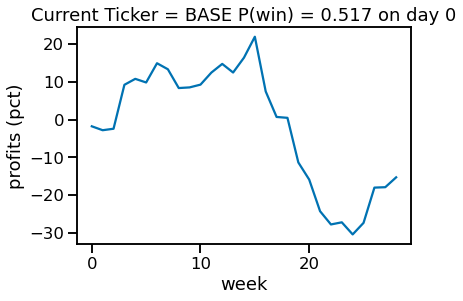

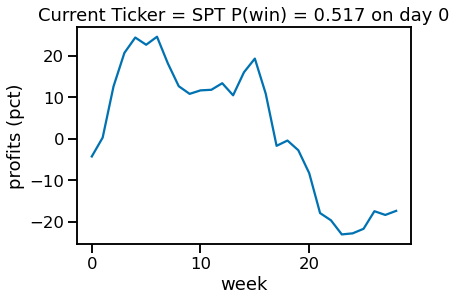

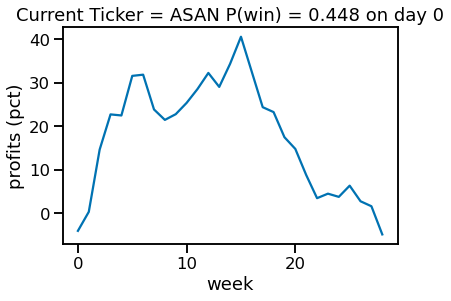

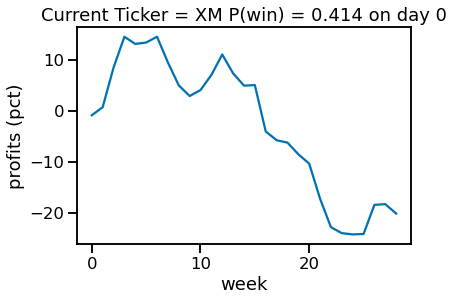

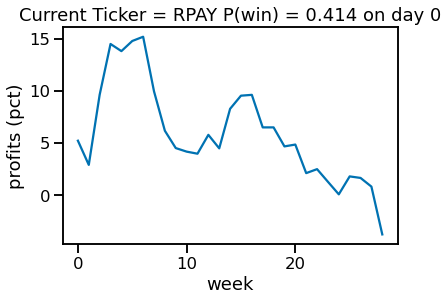

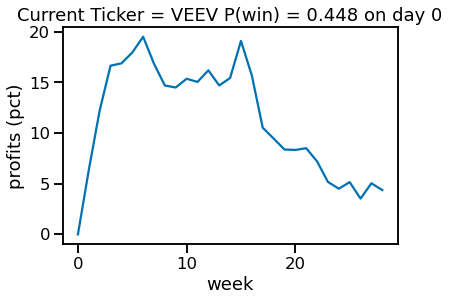

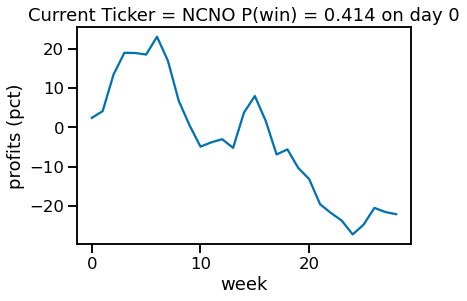

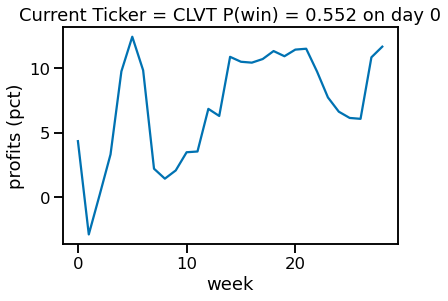

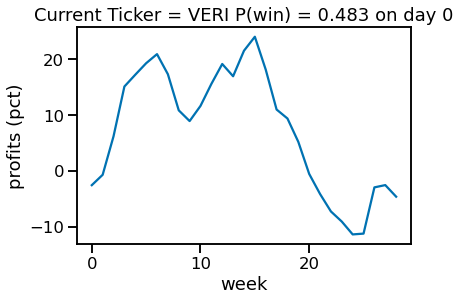

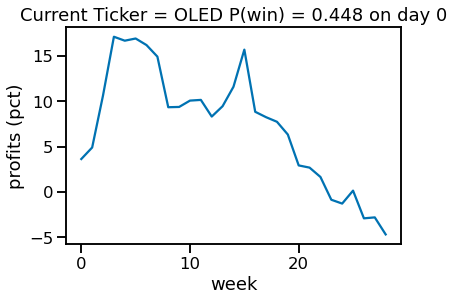

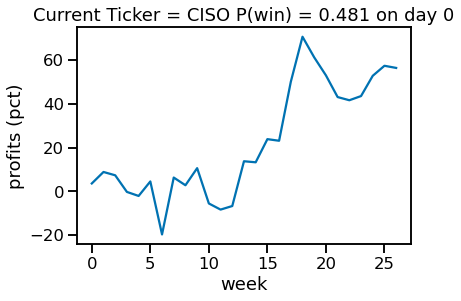

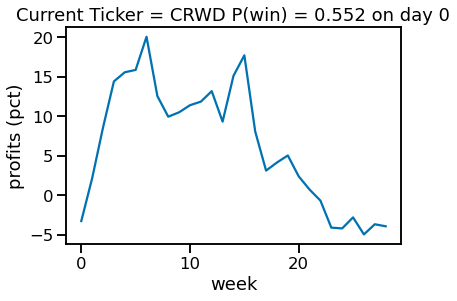

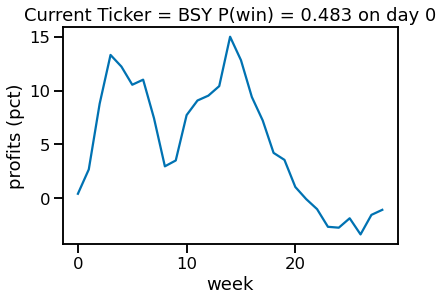

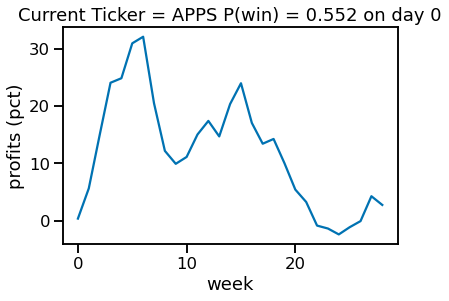

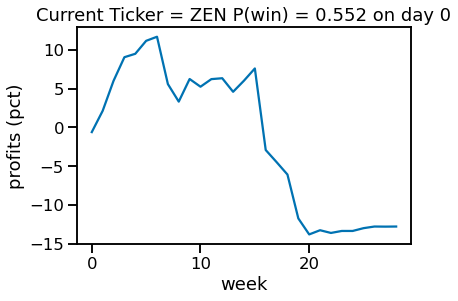

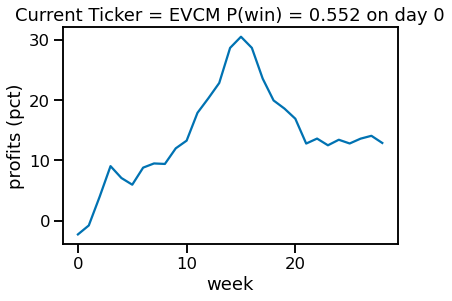

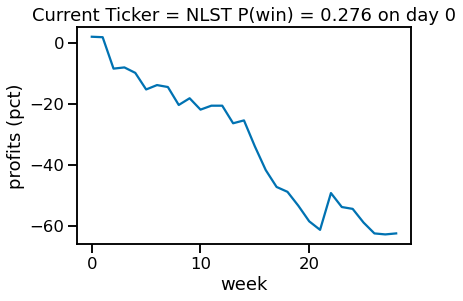

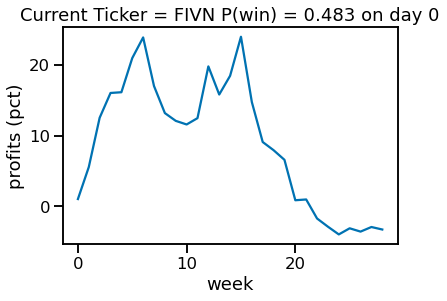

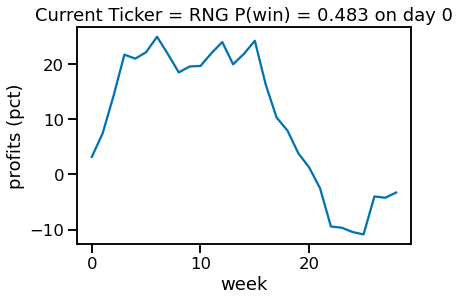

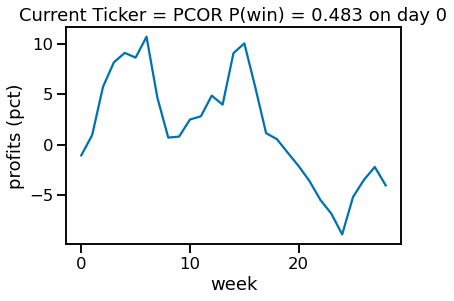

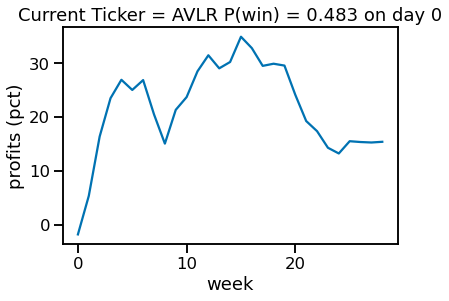

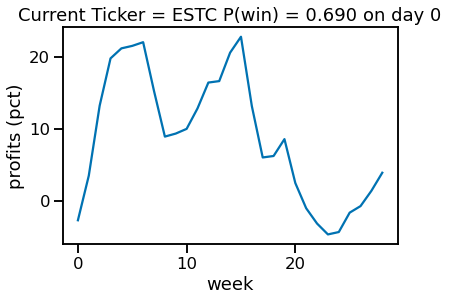

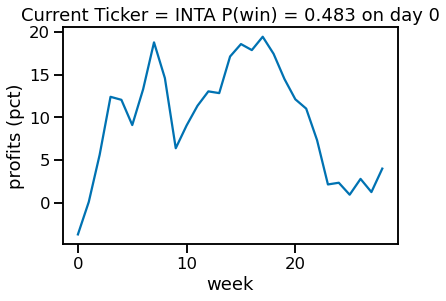

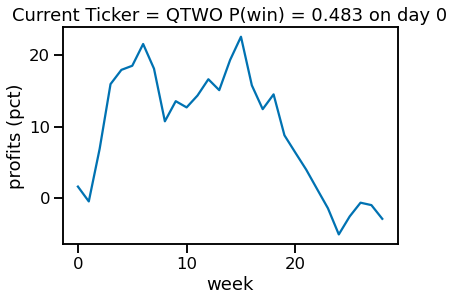

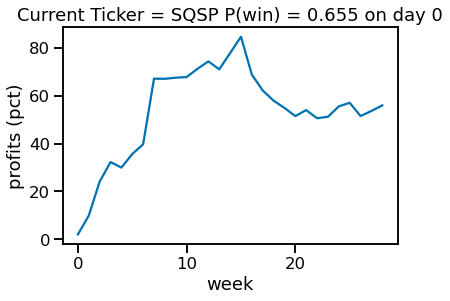

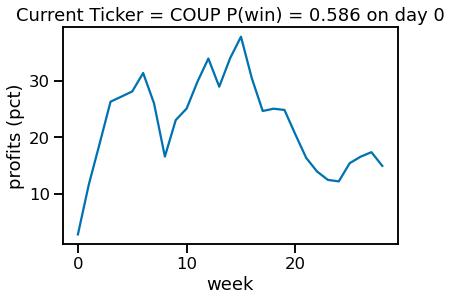

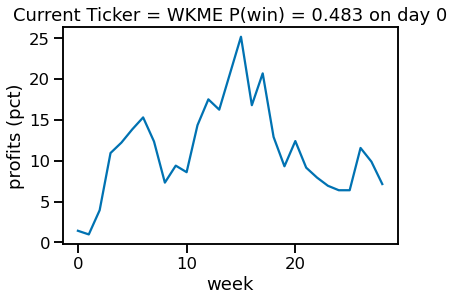

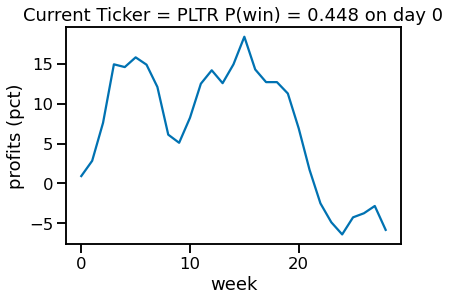

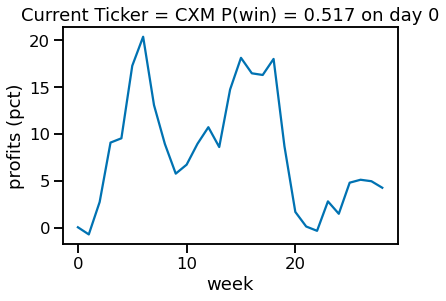

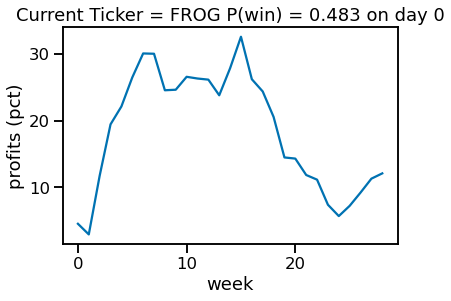

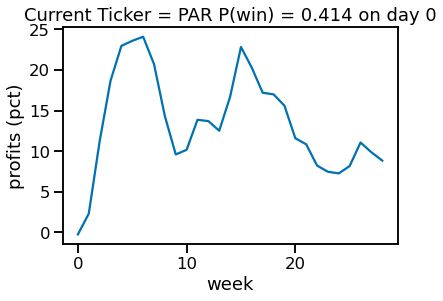

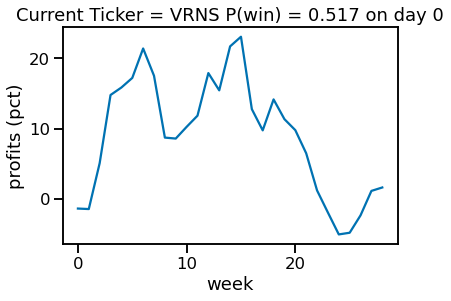

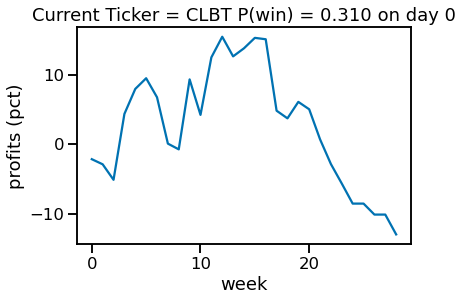

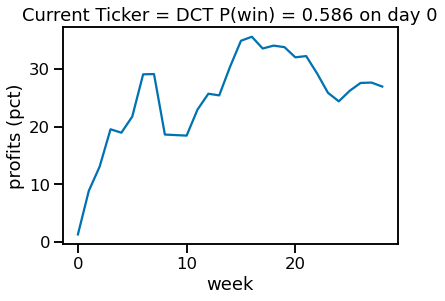

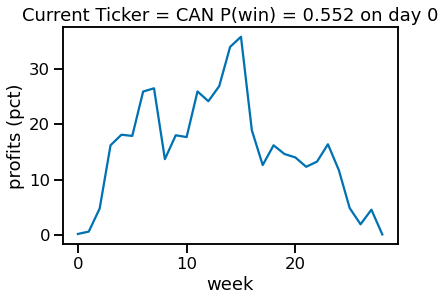

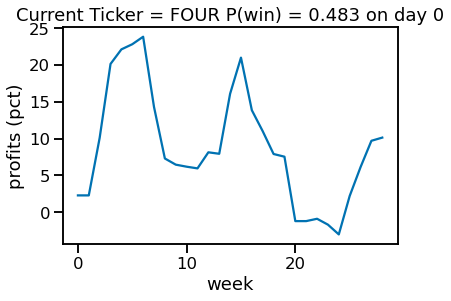

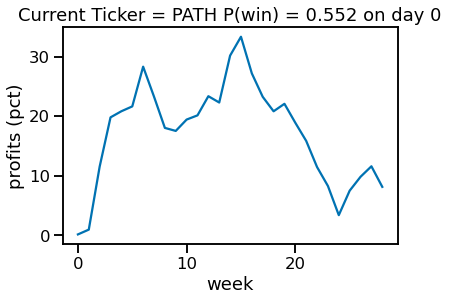

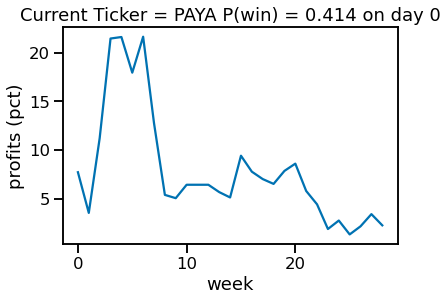

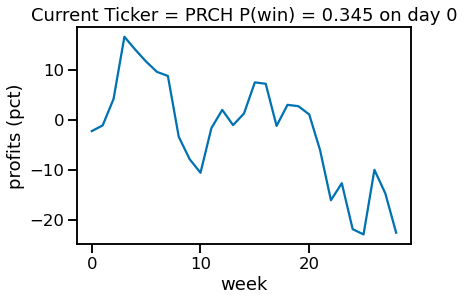

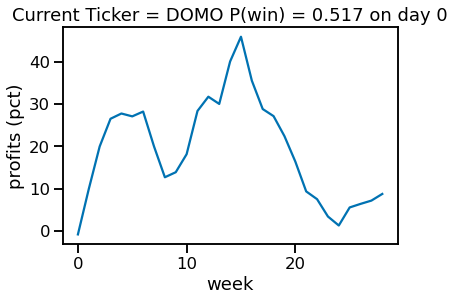

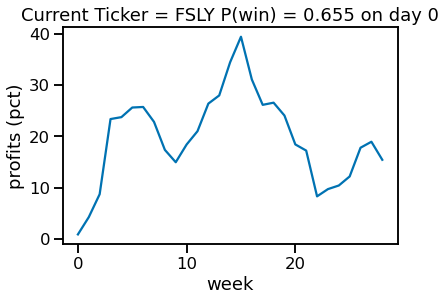

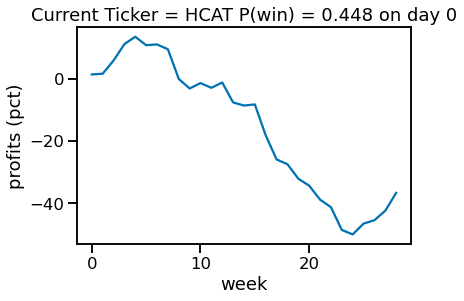

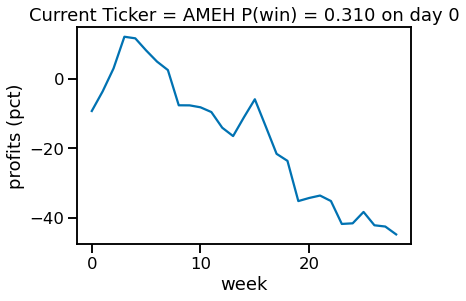

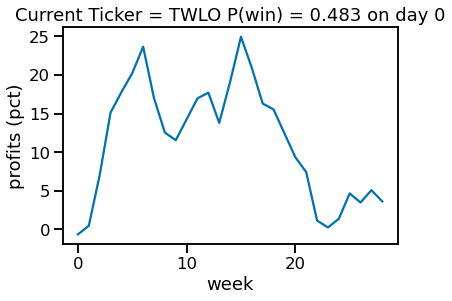

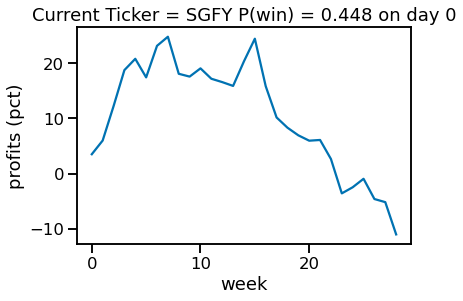

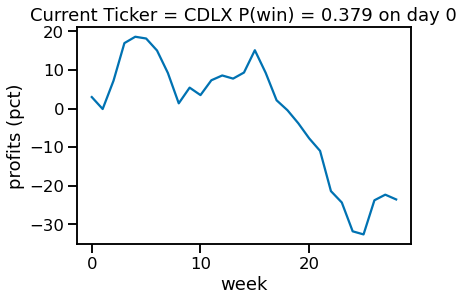

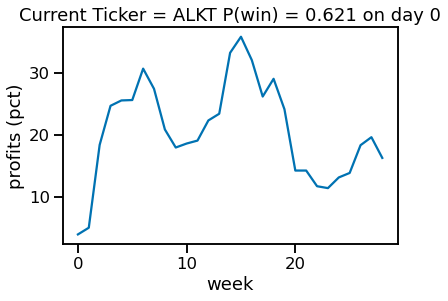

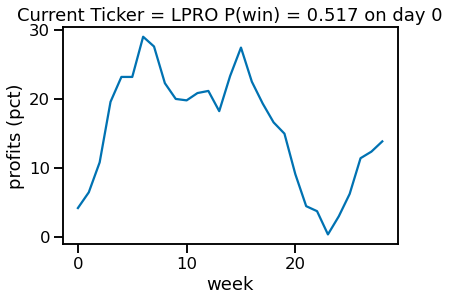

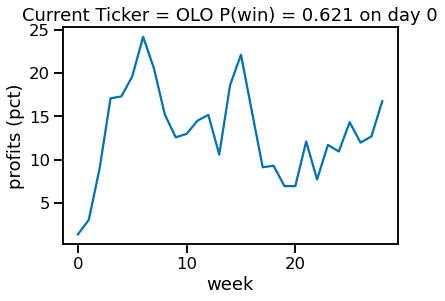

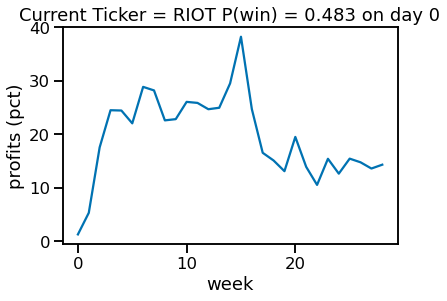

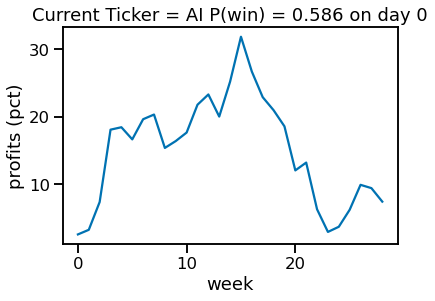

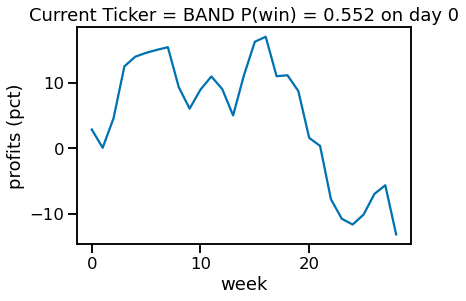

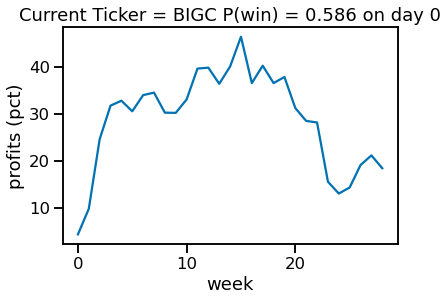

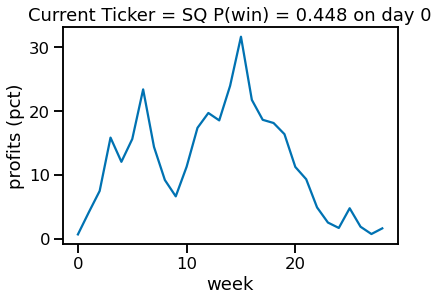

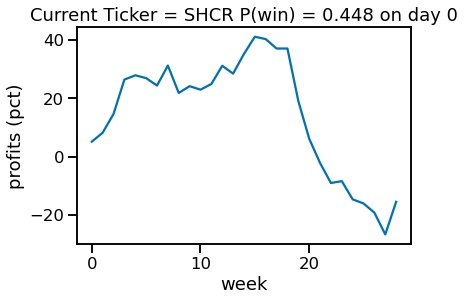

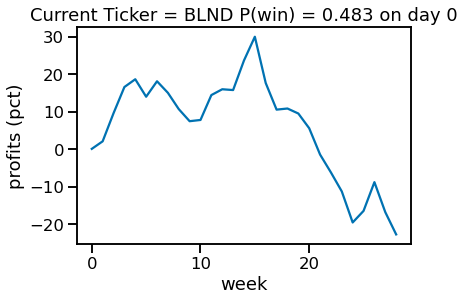

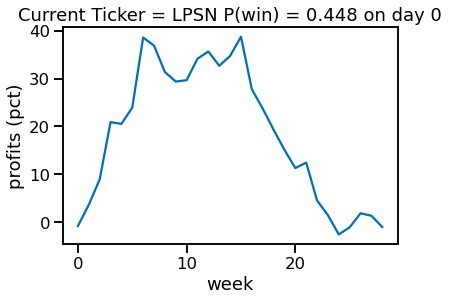

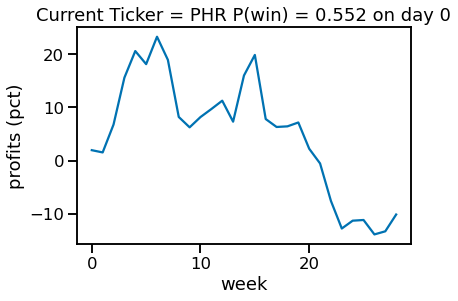

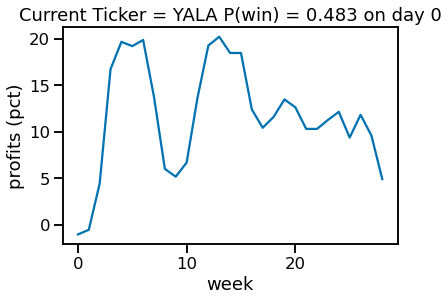

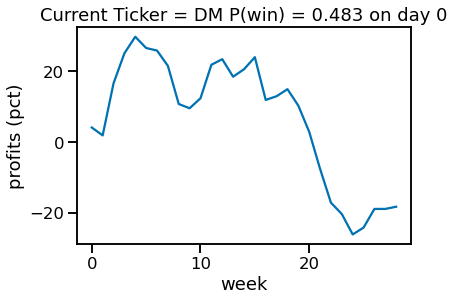

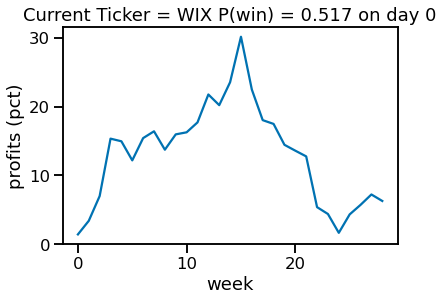

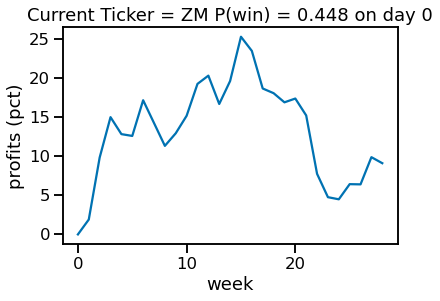

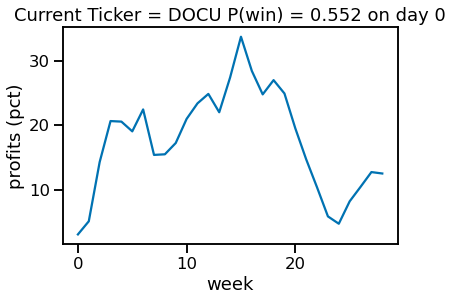

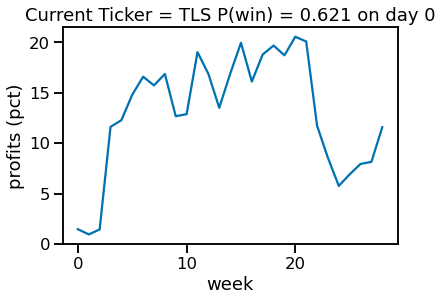

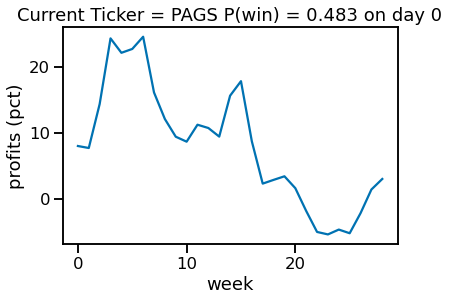

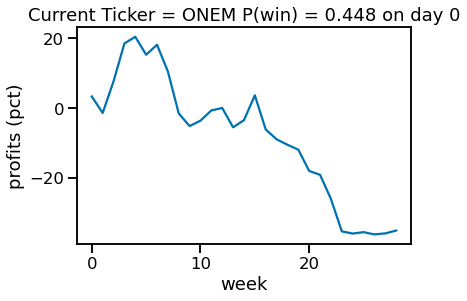

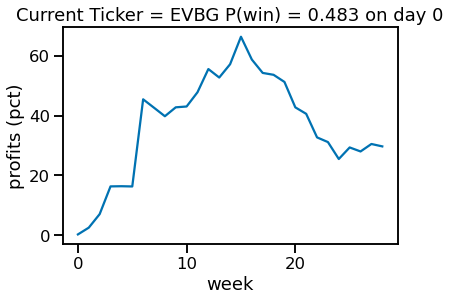

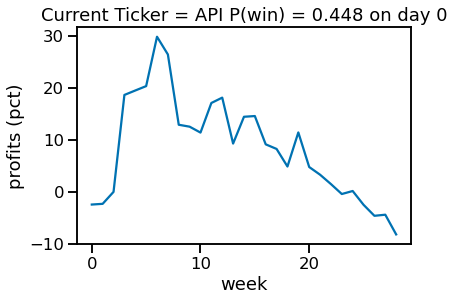

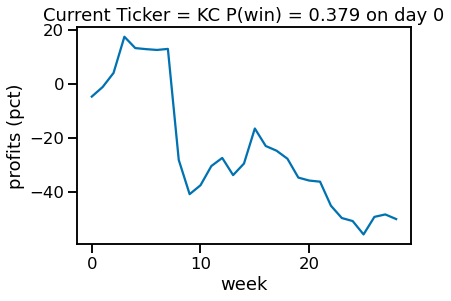

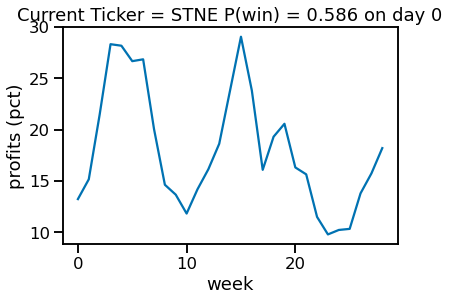

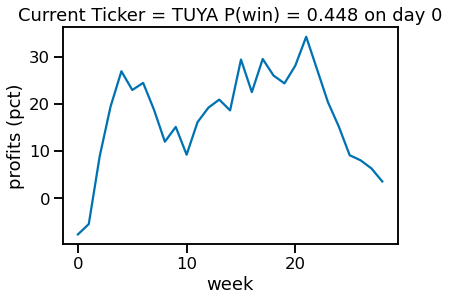

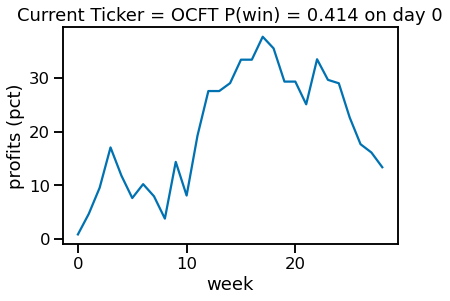

In [3]:
df = pd.read_csv("/Users/sandeep/Workspace/APEX/RecoveryStocksArbitrage/Yash_Recovery_Stocks.csv")
df = clean_data(df)

historical_data = get_historical_data(df, '2022-01-01', '2022-08-23', '1d')
backtest_data = backtest_monday(historical_data)

In [1]:
# import yfinance as yf

# # Data gathering
# historical_data = dict()

# # map ticker labels to their corresponding 3mo historical data
# for ticker in df['Ticker']:
#     ticker = ticker.replace(" ","")
#     #Lets look at the last 3m of data
#     data = yf.Ticker(ticker).history(start='2021-11-01', end='2022-01-29', interval="1d")
#     # Add day of the week so we can start to see weekly patterns
#     data = data.reset_index(0)
#     data['Dayofweek'] = pd.to_datetime(data['Date']).dt.dayofweek
#     data = data.drop(columns=['High','Low','Dividends', 'Stock Splits'])
#     data['Intraday'] = data['Close'] / data['Open']
#     data = data.reindex(columns = ['Date', 'Dayofweek', 'Open', 'Close', 'Volume', 'Intraday'])
#     historical_data[ticker] = data


In [5]:
# backtest_data = dict()
# for ticker, data in historical_data.items():
#     # print(f'Current Ticker: {ticker}')
#     for i in range(0,5):
#         profits = backtest_in_percent(data, day= i)
#         backtest_data[f'{ticker}_day_{i}'] = profits
#         plot_profits_pct(ticker, profits, day = i) 

In [6]:
# backtest_data_mon = dict()
# backtest_data_tue = dict()
# backtest_data_wed = dict()
# backtest_data_thu = dict()
# backtest_data_fri = dict()

# for ticker, data in historical_data.items():
#     backtest_data_mon[ticker] = backtest_in_percent(data, 0)
#     backtest_data_tue[ticker] = backtest_in_percent(data, 1)
#     backtest_data_wed[ticker] = backtest_in_percent(data, 2)
#     backtest_data_thu[ticker] = backtest_in_percent(data, 3)
#     backtest_data_fri[ticker] = backtest_in_percent(data, 4)

In [7]:
# # Lets start by analyzing mondays
# import statistics as st
# # df_mon = pd.DataFrame(backtest_data_mon)

# def verify_data_length(dictionary, req_len):
#     bad = []
#     for k,v in dictionary.items():
#         if len(v) < req_len:
#             bad.append(k)
#     for b in bad:
#         dictionary.pop(b)

#     return dictionary

In [8]:
# backtest_data_mon = verify_data_length(backtest_data_mon, 12)
# backtest_data_tue = verify_data_length(backtest_data_tue, 12)
# backtest_data_wed= verify_data_length(backtest_data_wed, 12)
# backtest_data_thu = verify_data_length(backtest_data_thu, 12)
# backtest_data_fri = verify_data_length(backtest_data_fri, 11)

In [9]:
# TAX_RATE = 0.35

In [10]:
# df_mon = pd.DataFrame(backtest_data_mon)
# # df_mon.head()
# mon_agg_stats = dict()
# for x in df_mon.columns:
#    mon_agg_stats[x] = ["min", "max", "median", "mean", "std"]

# mon_stats_df = df_mon.agg(mon_agg_stats)
# # mon_stats_df.head()

# mon_sharpes = dict()
# for tick in mon_stats_df.columns:
#     mon_sharpes[tick] = mon_stats_df[tick]['mean']*TAX_RATE / mon_stats_df[tick]['std']
# mon_stats_df = mon_stats_df.append(mon_sharpes, ignore_index=True)
# mon_stats_df.index = ["min", "max", "median", "mean", "std", "sharpe"]

# mon_stats_df = mon_stats_df.transpose()
# mon_stats_df.sort_values(axis = 0, by="sharpe", ascending=False)

In [11]:
# df_tue = pd.DataFrame(backtest_data_tue)
# # df_tue.head()

# tue_agg_stats = dict()
# for x in df_tue.columns:
#    tue_agg_stats[x] = ["min", "max", "median", "mean", "std"]

# tue_stats_df = df_tue.agg(tue_agg_stats)
# # tue_stats_df.head()

# tue_sharpes = dict()
# for tick in tue_stats_df.columns:
#    tue_sharpes[tick] = tue_stats_df[tick]['mean']*TAX_RATE / tue_stats_df[tick]['std']
# tue_stats_df = tue_stats_df.append(tue_sharpes, ignore_index=True)
# tue_stats_df.index = ["min", "max", "median", "mean", "std", "sharpe"]

# tue_stats_df = tue_stats_df.transpose()
# tue_stats_df.sort_values(axis = 0, by="sharpe", ascending=False)
# tue_stats_df

In [12]:
# df_wed = pd.DataFrame(backtest_data_wed)
# # df_tue.head()

# wed_agg_stats = dict()
# for x in df_wed.columns:
#    wed_agg_stats[x] = ["min", "max", "median", "mean", "std"]

# wed_stats_df = df_wed.agg(wed_agg_stats)
# # tue_stats_df.head()

# wed_sharpes = dict()
# for tick in wed_stats_df.columns:
#    wed_sharpes[tick] = wed_stats_df[tick]['mean']*TAX_RATE / wed_stats_df[tick]['std']
# wed_stats_df = wed_stats_df.append(wed_sharpes, ignore_index=True)
# wed_stats_df.index = ["min", "max", "median", "mean", "std", "sharpe"]

# wed_stats_df = wed_stats_df.transpose()
# wed_stats_df.sort_values(axis = 0, by="sharpe", ascending=False)
# wed_stats_df

In [13]:
df_thu = pd.DataFrame(backtest_data_thu)
# df_tue.head()

thu_agg_stats = dict()
for x in df_thu.columns:
   thu_agg_stats[x] = ["min", "max", "median", "mean", "std"]

thu_stats_df = df_thu.agg(thu_agg_stats)
# tue_stats_df.head()

thu_sharpes = dict()
for tick in thu_stats_df.columns:
   thu_sharpes[tick] = thu_stats_df[tick]['mean']*TAX_RATE / thu_stats_df[tick]['std']
thu_stats_df = thu_stats_df.append(thu_sharpes, ignore_index=True)
thu_stats_df.index = ["min", "max", "median", "mean", "std", "sharpe"]

thu_stats_df = thu_stats_df.transpose()
thu_stats_df.sort_values(axis = 0, by="sharpe", ascending=False)
thu_stats_df

NameError: name 'backtest_data_thu' is not defined

In [ ]:
# df_fri = pd.DataFrame(backtest_data_fri)
# fri_agg_stats = dict()
# for x in df_fri.columns:
#    fri_agg_stats[x] = ["min", "max", "median", "mean", "std"]

# fri_stats_df = df_fri.agg(fri_agg_stats)
# # tue_stats_df.head()

# fri_sharpes = dict()
# for tick in fri_stats_df.columns:
#    fri_sharpes[tick] = fri_stats_df[tick]['mean']*TAX_RATE / fri_stats_df[tick]['std']
# fri_stats_df = fri_stats_df.append(fri_sharpes, ignore_index=True)
# # fri_stats_df
# fri_stats_df.index = ["min", "max", "median", "mean", "std", "sharpe"]

# fri_stats_df = fri_stats_df.transpose()
# fri_stats_df.sort_values(axis = 0, by="sharpe", ascending=False)
# fri_stats_df